# GRL Exam, MT 2022
## Question 3 code

### Imports, etc.

In [ ]:
!python -c "import torch; print(torch.__version__)"

1.13.0+cu116


In [ ]:
%%capture
%env TORCH=1.13.0+cu116
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

In [ ]:
import torch
import torch.nn as nn
import torch_geometric.nn as geom_nn
import numpy as np
import torch.nn.functional as F
from torch import optim

import torch_geometric.utils as U
import os

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set(font_scale=1)
sns.set_style('whitegrid')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


### Core implementation

In [ ]:
def compute_hops(A, max_hops):
    """
    Returns a list of adjacency matrices for each `k`-neighbourhood from `1` to
    `max_hops`.
    """
    As = [A]
    hop_A = A
    i = 0
    while i < max_hops - 1:
        neighA = torch.mm(hop_A, A)
        # remove previous hops neighbours
        ors = torch.zeros_like(A)
        for prev in As:
            ors = torch.logical_or(ors, prev)
        # remove where previous neighbours already exist 
        hop_A = torch.where(torch.logical_and(neighA >= 1, ors >= 1), torch.zeros_like(neighA), torch.ones_like(neighA)).to(device)
        As += [hop_A]
        i += 1
    return As

In [ ]:
def compute_combined_hops(A, max_hops):
    """
    Returns an adjacency matrix with edges added to each k-neighbourhood from `1`
    to `max_hops`.
    """
    A_pow = A
    A_res = A
    i = 1
    while i < max_hops:
        A_pow = torch.mm(A_pow, A)
        A_pow = torch.where(A_pow > 1, torch.ones_like(A_pow), A_pow)
        A_res = torch.logical_or(A_res, A_pow)
        i += 1
    return A_res

In [ ]:
# Implementation inspired by https://github.com/Diego999/pyGAT/blob/master/layers.py

class GATLayer(nn.Module):
    """
    Graph Attention Network layer, defined in https://arxiv.org/pdf/1710.10903.pdf.
    """

    def __init__(self, in_features, out_features, alpha=0.2, p=0.6, act=nn.ELU):
        """
        `in_features`: number of input features
        `out_features`: number of output features
        `alpha`: negative slope coefficient of the LeakyReLU used to compute the
                 attention coefficients (default is the value used in the paper)
        `act`: the activation function (ELU by default, as in the paper)
        """
        super().__init__()
        self.W = nn.Parameter(nn.init.xavier_uniform_(torch.rand(in_features, out_features)))

        self.a1 = nn.Parameter(nn.init.xavier_uniform_(torch.rand(out_features, 1)))
        self.a2 = nn.Parameter(nn.init.xavier_uniform_(torch.rand(out_features, 1)))

        self.act = act() if act is not None else None
        self.p = p

        self.leaky = nn.LeakyReLU(alpha)

    def forward(self, X, A):
        X = torch.mm(X, self.W)
        attention = self.compute_attention(X, A)
        attention = F.dropout(attention, p=self.p, training=self.training)
        X = torch.mm(attention, X)
        if self.act is None:
            return X
        return self.act(X)

    def compute_attention(self, X, A):
        att1 = torch.mm(X, self.a1)
        att2 = torch.mm(X, self.a2)

        e = att1 + att2.T
        e = self.leaky(e)

        zeros = -9e15 * torch.ones_like(A)  # so that exp(-x) ~ 0
        attention = torch.where(A > 0, e, zeros)
        attention = F.softmax(attention, dim=1)

        return attention


In [ ]:
class GATModule(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, hops=1):
        super().__init__()
        in_dim = lambda i: hidden_dim if i != 0 else input_dim
        out_dim = lambda i: hidden_dim if i != num_layers - 1 else output_dim

        self.layers = nn.ModuleList([GATLayer(in_dim(i), out_dim(i)) for i in range(num_layers)])
        self.hops = hops

    def forward(self, X, A):
        Ac = A
        if self.hops != 1:
            Ac = compute_combined_hops(A, max_hops=self.hops)

        for layer in self.layers:
            X = layer(X, Ac)
        return X

    def reset_parameters(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()


In [ ]:
class SSSPGATLayer(nn.Module):
    """
    The k-MHGAT implementation.
    """
    def __init__(self, in_features, out_features, heads=3):
        """
        `heads`: the number of neighbourhoods that should be combined. (The k
        of the k-MHGAT.)
        """
        super().__init__()

        self.heads = heads

        h = [GATLayer(in_features, out_features, act=None) for _ in range(heads)]
        self.gats = nn.Sequential(*h)
        self.W_comb = nn.Parameter(nn.init.xavier_uniform_(torch.rand(heads*out_features, out_features)))
        self.act = nn.ELU()

    def forward(self, X, A):
        XS = []
        for i, gat in enumerate(self.gats):
            XS += [gat(X, self.As[i])]
        
        # aggregate all together
        cat = torch.cat(XS, dim=1)
        out = torch.mm(cat, self.W_comb)
        return self.act(out)

In [ ]:
class SSSPGATModule(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, heads=2):
        super().__init__()
        in_dim = lambda i: hidden_dim if i != 0 else input_dim
        out_dim = lambda i: hidden_dim if i != num_layers - 1 else output_dim

        self.layers = nn.ModuleList([SSSPGATLayer(in_dim(i), out_dim(i), heads=heads) for i in range(num_layers)])
        self.heads = heads

    def forward(self, X, A):
        As = compute_hops(A, self.heads)

        for layer in self.layers:
            layer.As = As
            X = layer(X, As)
        return X

    def reset_parameters(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()


### Training functions

In [ ]:
# Define the hyperparameters we are gonna use:
params = {
    "hidden_features": 64,
    "n_layers": 2,
    "learning_rate": 5 * 1e-2,
    "weight_decay": 0,
    "num_epochs": 500,
    
    "loss_function": nn.CrossEntropyLoss,
    "optimizer_type": optim.SGD,
}

In [ ]:
from torch_geometric.datasets import Planetoid

def load_cora():
    return Planetoid("/tmp/Cora", name="Cora")

In [ ]:
def test(model, data, A, params):
    model.eval()

    test_accuracy = 0
    with torch.no_grad():
        out = model(data.x, A)
        out = torch.argmax(out, dim=1)
        test_accuracy = torch.count_nonzero((out[data.test_mask] == data.y[data.test_mask])) / data.y[data.test_mask].size()[0]

    return test_accuracy

In [ ]:
def train(model, data, adj_matrix, params):
    optimizer = params["optimizer_type"](model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
    criterion = params["loss_function"]()
    losses = []
    accuracies = []
    test_acc = []

    for i in range(params["num_epochs"]):
        model.train()
        optimizer.zero_grad()

        out = model(data.x, adj_matrix)
        res = torch.argmax(out[data.train_mask], dim=1)

        accuracies += [torch.mean((res == data.y[data.train_mask]).float()).item()]
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        
        loss.backward()
        optimizer.step()

        losses += [loss.item()]
        test_accuracy = test(model, data, adj_matrix, params)
        test_acc += [test_accuracy.item()]

    return losses, accuracies, test_acc


### Results

In [ ]:
class CmpModule():
    def __init__(self, impl, name):
        self.impl = impl
        self.name = name

In [ ]:
def compare_perf(dataset, models):
    dataset.data.to(device)
    num_nodes = dataset.data.num_nodes
    num_edges = dataset.data.num_edges // 2
    num_features = dataset.num_node_features
    num_classes = dataset.num_classes

    A = U.to_dense_adj(dataset.data.edge_index).squeeze(0)
    A = A + torch.diag(torch.ones((A.size(0)))).to(device)  # add self-loops

    for model in models:
        print(f"--- MODEL '{model.name}' ---")
        m = model.impl(num_features, params["hidden_features"], num_classes, params["n_layers"]).to(device)
        losses, accs, test_acc = train(m, dataset.data, A, params)
        print(f"Best accuracy: {max(test_acc)}")
        plt.plot(test_acc, label=model.name)

    plt.legend(loc='lower right')
    plt.gcf().savefig(os.getcwd() + "/output/accuracy.pdf", format="pdf", bbox_inches='tight')
    plt.show()

--- MODEL 'GAT' ---
Best accuracy: 0.8100000619888306
--- MODEL '2-HGAT' ---
Best accuracy: 0.7820000648498535
--- MODEL '3-HGAT' ---
Best accuracy: 0.7390000224113464
--- MODEL '2-MHGAT' ---
Best accuracy: 0.7820000648498535
--- MODEL '3-MHGAT' ---
Best accuracy: 0.7820000648498535


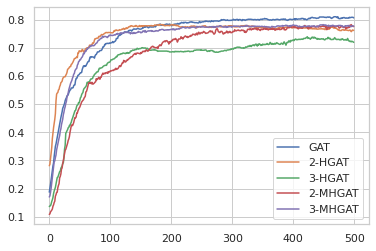

In [ ]:
compare_perf(load_cora(), [
    CmpModule(lambda in_feat, hid_feat, out_feat, layers: GATModule(in_feat, hid_feat, out_feat, layers, hops=1), 'GAT'),
    CmpModule(lambda in_feat, hid_feat, out_feat, layers: GATModule(in_feat, hid_feat, out_feat, layers, hops=2), '2-HGAT'),
    CmpModule(lambda in_feat, hid_feat, out_feat, layers: GATModule(in_feat, hid_feat, out_feat, layers, hops=3), '3-HGAT'),

    CmpModule(lambda in_feat, hid_feat, out_feat, layers: SSSPGATModule(in_feat, hid_feat, out_feat, layers, heads=2), '2-MHGAT'),
    CmpModule(lambda in_feat, hid_feat, out_feat, layers: SSSPGATModule(in_feat, hid_feat, out_feat, layers, heads=3), '3-MHGAT'),
])

In [ ]:
def compare_oversquashing(dataset, min_layers, max_layers, models, step=2):
    dataset.data.to(device)
    num_nodes = dataset.data.num_nodes
    num_edges = dataset.data.num_edges // 2
    num_features = dataset.num_node_features
    num_classes = dataset.num_classes

    A = U.to_dense_adj(dataset.data.edge_index).squeeze(0)
    A = A + torch.diag(torch.ones((A.size(0)))).to(device)  # add self-loops
    macc = {}

    for model in models:
        macc[model.name] = []
        for i in range(min_layers, max_layers + 1, step):
            print(f"--- MODEL '{model.name}', layers={i} ---")
            m = model.impl(num_features, params["hidden_features"], num_classes, i).to(device)
            losses, accs, test_acc = train(m, dataset.data, A, params)
            macc[model.name] += [test_acc[-1]]  # append final accuracy
            print(f"Final acc: {test_acc[-1]}")
            print(f"Final train acc: {accs[-1]}")


    xticks = np.arange((max_layers - min_layers) / step + 1) * step + min_layers
    for k, v in macc.items():
        plt.plot(xticks, v, label=k)
    
    plt.xticks(xticks, xticks)
    plt.legend(loc='lower right')
    plt.gcf().savefig(os.getcwd() + "/output/oversquashing.pdf", format="pdf", bbox_inches='tight')
    plt.show()

--- MODEL 'GAT', layers=2 ---
Final acc: 0.8100000619888306
Final train acc: 0.8285714387893677
--- MODEL 'GAT', layers=4 ---
Final acc: 0.8090000152587891
Final train acc: 0.7571428418159485
--- MODEL 'GAT', layers=6 ---
Final acc: 0.76500004529953
Final train acc: 0.75
--- MODEL 'GAT', layers=8 ---
Final acc: 0.7950000166893005
Final train acc: 0.7642857432365417
--- MODEL 'GAT', layers=10 ---
Final acc: 0.7660000324249268
Final train acc: 0.75
--- MODEL '2-HGAT', layers=2 ---
Final acc: 0.7780000567436218
Final train acc: 0.8357142806053162
--- MODEL '2-HGAT', layers=4 ---
Final acc: 0.7770000100135803
Final train acc: 0.8785714507102966
--- MODEL '2-HGAT', layers=6 ---
Final acc: 0.753000020980835
Final train acc: 0.8214285969734192
--- MODEL '2-HGAT', layers=8 ---
Final acc: 0.7600000500679016
Final train acc: 0.7928571701049805
--- MODEL '2-HGAT', layers=10 ---
Final acc: 0.6000000238418579
Final train acc: 0.7142857313156128
--- MODEL '3-HGAT', layers=2 ---
Final acc: 0.74800002

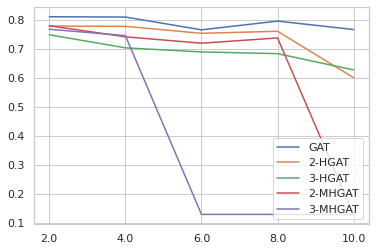

In [ ]:
compare_oversquashing(load_cora(), 2, 10, [
    CmpModule(lambda in_feat, hid_feat, out_feat, layers: GATModule(in_feat, hid_feat, out_feat, layers, hops=1), 'GAT'),
    CmpModule(lambda in_feat, hid_feat, out_feat, layers: GATModule(in_feat, hid_feat, out_feat, layers, hops=2), '2-HGAT'),
    CmpModule(lambda in_feat, hid_feat, out_feat, layers: GATModule(in_feat, hid_feat, out_feat, layers, hops=3), '3-HGAT'),

    CmpModule(lambda in_feat, hid_feat, out_feat, layers: SSSPGATModule(in_feat, hid_feat, out_feat, layers, heads=2), '2-MHGAT'),
    CmpModule(lambda in_feat, hid_feat, out_feat, layers: SSSPGATModule(in_feat, hid_feat, out_feat, layers, heads=3), '3-MHGAT'),
])

### Other attempts (you may ignore this part)

#### Summed k-adjacency GAT

In [ ]:
def summed_adj(dataset, ks=[]):
    for k in ks:
        dataset.data.to(device)
        num_nodes = dataset.data.num_nodes
        num_edges = dataset.data.num_edges // 2
        num_features = dataset.num_node_features
        num_classes = dataset.num_classes

        model = GATModule(num_features, params["hidden_features"], num_classes, params["n_layers"])
        model.to(device)

        A = U.to_dense_adj(dataset.data.edge_index).squeeze(0)
        A = A + torch.diag(torch.ones((A.shape[0]))).to(device)  # add self-loops

        A_res = A
        A_pow = A
        i = 1
        while i < k:
            A_pow = torch.mm(A_pow, A)
            A_res = A_res + A_pow
            i += 1

        losses, accs, test_accs = train(model, dataset.data, A_res, params)
        test_acc = test(model, dataset.data, A, params)
        print(f'Best for k={k} acc: {max(test_accs)}')
        import matplotlib.pyplot as plt

        plt.plot(test_accs, label=f'k={k}')
        plt.legend()
    plt.show()

Best for k=1 acc: 0.8110000491142273
Best for k=2 acc: 0.781000018119812
Best for k=3 acc: 0.7250000238418579
Best for k=4 acc: 0.6680000424385071
Best for k=5 acc: 0.48000001907348633


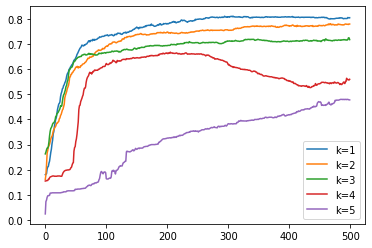

In [ ]:
summed_adj(load_cora(), ks=[1, 2, 3, 4, 5])

Best for k=5 acc: 0.46000000834465027


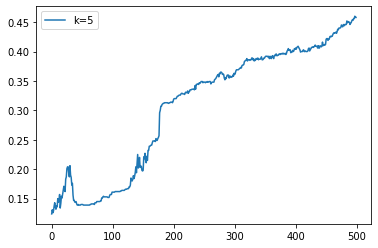

In [ ]:
summed_adj(load_cora(), ks=[5])

#### Filling + random dropout of higher powers

In [ ]:
def or_adj_dropout(dataset, ks, p):
    for k in ks:
        dataset.data.to(device)
        num_nodes = dataset.data.num_nodes
        num_edges = dataset.data.num_edges // 2
        num_features = dataset.num_node_features
        num_classes = dataset.num_classes

        model = GATModule(num_features, params["hidden_features"], num_classes, params["n_layers"])
        model.to(device)

        A = U.to_dense_adj(dataset.data.edge_index).squeeze(0)
        A = A + torch.diag(torch.ones((A.shape[0]))).to(device)  # add self-loops

        A_pow = A
        A_res = A
        i = 1
        while i < k:
            A_pow = torch.mm(A_pow, A)
            A_pow = torch.where(A_pow > 1, torch.ones_like(A_pow), A_pow)
            A_res = torch.logical_or(A_res, F.dropout(A_pow, p=p))
            i += 1

        losses, accs, test_accs = train(model, dataset.data, A_res, params)
        print(f'Best for k={k} acc: {max(test_accs)}')
        test_acc = test(model, dataset.data, A, params)
        import matplotlib.pyplot as plt

        plt.plot(test_accs, label=f'k={k}')
        plt.legend()
    plt.show()

Best for k=1 acc: 0.8170000314712524
Best for k=2 acc: 0.8030000329017639
Best for k=3 acc: 0.7400000095367432
Best for k=4 acc: 0.6730000376701355
Best for k=5 acc: 0.5710000395774841


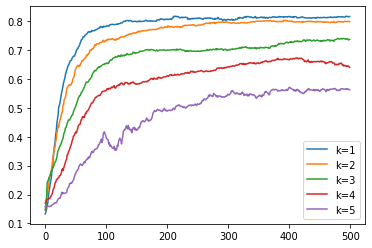

In [ ]:
or_adj_dropout(load_cora(), [1, 2, 3, 4, 5], 0.9)

Best for k=1 acc: 0.8190000653266907
Best for k=2 acc: 0.781000018119812
Best for k=3 acc: 0.7220000624656677
Best for k=4 acc: 0.690000057220459
Best for k=5 acc: 0.42600002884864807


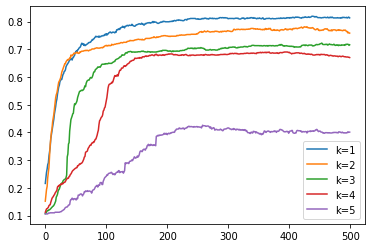

In [ ]:
or_adj_dropout(load_cora(), [1, 2, 3, 4, 5], 0.1)

Best for k=1 acc: 0.7990000247955322
Best for k=2 acc: 0.7830000519752502
Best for k=3 acc: 0.7290000319480896
Best for k=4 acc: 0.5740000009536743
Best for k=5 acc: 0.44600000977516174


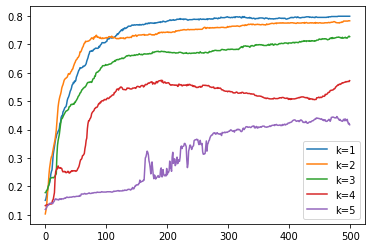

In [ ]:
or_adj_dropout(load_cora(), [1, 2, 3, 4, 5], 0.45)

#### Random weights adjacency

In [ ]:
def try_rand_weights(dataset):
    dataset.data.to(device)
    num_nodes = dataset.data.num_nodes
    num_edges = dataset.data.num_edges // 2
    num_features = dataset.num_node_features
    num_classes = dataset.num_classes

    model = GATModule(num_features, params["hidden_features"], num_classes, params["n_layers"])
    model.to(device)

    A = U.to_dense_adj(dataset.data.edge_index).squeeze(0)
    A = A + torch.diag(torch.ones((A.shape[0]))).to(device)  # add self-loops
    # add random weights to adjacency matrix
    RW = 100000 * torch.rand_like(A)
    A = torch.where(A > 0, RW, A)
    print(A)
    losses, accs, test_accs = train(model, dataset.data, A, params)
    test_acc = test(model, dataset.data, A, params)
    import matplotlib.pyplot as plt

    print(f'Best acc: {max(test_accs)}')
    plt.plot(losses)
    plt.plot(accs)
    plt.show()

    plt.plot(test_accs)
    plt.show()

tensor([[58726.4414,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0000, 13006.4775, 26614.9434,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0000, 49935.9180, 38321.5352,  ...,     0.0000,     0.0000,
             0.0000],
        ...,
        [    0.0000,     0.0000,     0.0000,  ..., 27397.2480,     0.0000,
             0.0000],
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000, 94620.9766,
         89154.1484],
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000, 97221.1250,
         33281.5664]], device='cuda:0')
Best acc: 0.8090000152587891


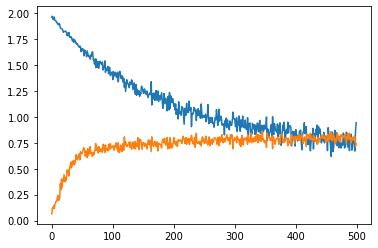

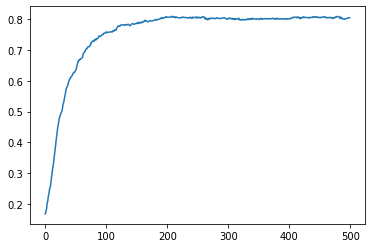

In [ ]:
try_rand_weights(load_cora())

In [ ]:
def try_rand_weights_readout(dataset):
    dataset.data.to(device)
    num_nodes = dataset.data.num_nodes
    num_edges = dataset.data.num_edges // 2
    num_features = dataset.num_node_features
    num_classes = dataset.num_classes

    model = GATReadoutModule(num_features, params["hidden_features"], num_classes, params["n_layers"])
    model.to(device)

    A = U.to_dense_adj(dataset.data.edge_index).squeeze(0)
    A = A + torch.diag(torch.ones((A.shape[0]))).to(device)  # add self-loops
    # add random weights to adjacency matrix
    RW = 100000 * torch.rand_like(A)
    A = torch.where(A > 0, RW, A)
    print(A)
    losses, accs, test_accs = train(model, dataset.data, A, params)
    test_acc = test(model, dataset.data, A, params)
    import matplotlib.pyplot as plt

    print(f'Best acc: {max(test_accs)}')
    plt.plot(losses)
    plt.plot(accs)
    plt.show()

    plt.plot(test_accs)
    plt.show()

tensor([[70883.2969,     0.0000,     0.0000,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0000,   961.5722,   642.8306,  ...,     0.0000,     0.0000,
             0.0000],
        [    0.0000, 83857.4609, 80257.7031,  ...,     0.0000,     0.0000,
             0.0000],
        ...,
        [    0.0000,     0.0000,     0.0000,  ..., 51416.7383,     0.0000,
             0.0000],
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000,   959.3353,
         61990.6562],
        [    0.0000,     0.0000,     0.0000,  ...,     0.0000, 59636.7969,
         57536.9531]], device='cuda:0')
Best acc: 0.8240000605583191


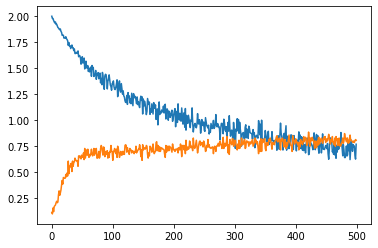

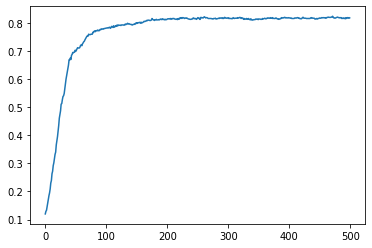

In [ ]:
try_rand_weights_readout(load_cora())